# **Instalación e importación de librerías**

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_md
!pip install transformers torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 23.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# **1. Carga de Datos y  Preprocesado**

In [ ]:
# Load the dataset
file_path = '/content/datos_es_unidos.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3150 non-null   int64 
 1   text        3150 non-null   object
 2   hashtags    1323 non-null   object
dtypes: int64(1), object(2)
memory usage: 74.0+ KB


In [ ]:
# Display the first few rows to inspect the content
print("\nFirst 5 Rows:")
print(df.head())


First 5 Rows:
   Unnamed: 0                                               text  \
0          27  ChatGPT para Mac: accede a la IA desde la barr...   
1          41  ¿Quieren aprender de ChatGPT 101? Gratis. \n\n...   
2          50  Cómo puede sacar provecho un emprendedor para ...   
3         100  Si no estás usando ChatGPT para tu trabajo o p...   
4         134  Alguien por ahí que también salude y le agrade...   

                                            hashtags  
0                                                NaN  
1                                                NaN  
2  Emprendedores, InteligenciaArtificial, Chatbot...  
3                                                NaN  
4                                                NaN  


In [ ]:
# Handle missing data
df = df.dropna(subset=['text', 'hashtags'])

# Convert all text to lowercase
df['text'] = df['text'].str.lower()

# Remove URLs, special characters, and extra whitespace from text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9áéíóúñü ]+', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Display the cleaned dataset
print("\nCleaned Data Sample:")
print(df[['text', 'clean_text', 'hashtags']].head())



Cleaned Data Sample:
                                                 text  \
2   cómo puede sacar provecho un emprendedor para ...   
6   📍¡últimos días!\n🔹no te olvides de enviar tu c...   
8   puedes iniciar con #chatgpt entrando a https:/...   
9   hoy vengo con un #prompt para #chatgpt que val...   
14  ☕️ ¿ya se tomaron su taza de datos para arranc...   

                                           clean_text  \
2   cómo puede sacar provecho un emprendedor para ...   
6   últimos díasno te olvides de enviar tu candida...   
8   puedes iniciar con chatgpt entrando a creas tu...   
9   hoy vengo con un prompt para chatgpt que vale ...   
14  ya se tomaron su taza de datos para arrancar e...   

                                             hashtags  
2   Emprendedores, InteligenciaArtificial, Chatbot...  
6                                AMETIC, AIAMSummit23  
8                                             ChatGPT  
9                                prompt, chatgpt, seo  
14  DataScie

<ipython-input-24-35adf24d1628>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.lower()
<ipython-input-24-35adf24d1628>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(clean_text)


In [ ]:
# Save the cleaned dataset to a new file for reference
cleaned_file_path = '/content/cleaned_tweets.xlsx'
df.to_excel(cleaned_file_path, index=False)

cleaned_file_path

'/content/cleaned_tweets.xlsx'

# **2. Language Normalization**

In [ ]:
# Language Normalization
# Define a list of common slang, abbreviations, and modisms specific to Latin American Spanish
normalization_dict = {
    "q": "que",
    "xq": "porque",
    "dnd": "donde",
    "tmb": "también",
    "ola": "hola",
    "ps": "pues",
    "k": "que",
    "d": "de",
    "vdd": "verdad",
    "pq": "porque",
    "sta": "está",
    "sto": "esto",
    "neta": "verdad",
    "chido": "bueno",
    "wey": "amigo",
    "pa": "para",
    "na": "nada",
    "vamo": "vamos"
}

In [ ]:
# Function to normalize text using the defined dictionary
def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)


In [ ]:
# Apply normalization to the clean_text column
df['normalized_text'] = df['clean_text'].apply(normalize_text)

# Display sample of normalized data
print("\nNormalized Data Sample:")
print(df[['clean_text', 'normalized_text']].head())


Normalized Data Sample:
                                           clean_text  \
2   cómo puede sacar provecho un emprendedor para ...   
6   últimos díasno te olvides de enviar tu candida...   
8   puedes iniciar con chatgpt entrando a creas tu...   
9   hoy vengo con un prompt para chatgpt que vale ...   
14  ya se tomaron su taza de datos para arrancar e...   

                                      normalized_text  
2   cómo puede sacar provecho un emprendedor para ...  
6   últimos díasno te olvides de enviar tu candida...  
8   puedes iniciar con chatgpt entrando a creas tu...  
9   hoy vengo con un prompt para chatgpt que vale ...  
14  ya se tomaron su taza de datos para arrancar e...  


In [ ]:
# Save the normalized dataset to a new file for reference
normalized_file_path = '/content/normalized_tweets.xlsx'
df.to_excel(normalized_file_path, index=False)

normalized_file_path

'/content/normalized_tweets.xlsx'

# **3. Tokenization and Stopword Removal**

In [ ]:
# Define custom stopwords for Latin American Spanish (additional to NLTK's list)
custom_stopwords = set(stopwords.words('spanish')).union({
    "chatgpt", "prompt", "data", "analytics", "python", "rstats", "seo",
    "emprendedores", "inteligenciaartificial", "dataviz"
})

In [ ]:
# Tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in custom_stopwords]
    return filtered_tokens

In [ ]:
# Apply tokenization and stopword removal to the normalized_text column
df['tokens'] = df['normalized_text'].apply(tokenize_and_remove_stopwords)

# Display sample of tokenized data
print("\nTokenized Data Sample:")
print(df[['normalized_text', 'tokens']].head())


Tokenized Data Sample:
                                      normalized_text  \
2   cómo puede sacar provecho un emprendedor para ...   
6   últimos díasno te olvides de enviar tu candida...   
8   puedes iniciar con chatgpt entrando a creas tu...   
9   hoy vengo con un prompt para chatgpt que vale ...   
14  ya se tomaron su taza de datos para arrancar e...   

                                               tokens  
2   [cómo, puede, sacar, provecho, emprendedor, sa...  
6   [últimos, díasno, olvides, enviar, candidatura...  
8   [puedes, iniciar, entrando, creas, cuenta, ini...  
9   [hoy, vengo, vale, demás, 100, mejores, sólo, ...  
14  [tomaron, taza, datos, arrancar, día, recuerde...  


In [ ]:
# Save the tokenized dataset to a new file for reference
tokenized_file_path = '/content/tokenized_tweets.xlsx'
df.to_excel(tokenized_file_path, index=False)

tokenized_file_path

'/content/tokenized_tweets.xlsx'

# **4. Named Entity Recognition (NER)**

In [ ]:
# Load pre-trained SpaCy model for Spanish
nlp = spacy.load('es_core_news_md'[35]
2 s
)

In [ ]:
# Function to extract named entities from text
def extract_named_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [ ]:
# Apply NER to the normalized_text column
df['named_entities'] = df['normalized_text'].apply(extract_named_entities)

In [ ]:
# Display sample of named entities
print("\nNamed Entities Sample:")
print(df[['normalized_text', 'named_entities']].head())


Named Entities Sample:
                                      normalized_text  \
2   cómo puede sacar provecho un emprendedor para ...   
6   últimos díasno te olvides de enviar tu candida...   
8   puedes iniciar con chatgpt entrando a creas tu...   
9   hoy vengo con un prompt para chatgpt que vale ...   
14  ya se tomaron su taza de datos para arrancar e...   

                                       named_entities  
2                                                  []  
6                 [(premios ia, MISC), (ametic, PER)]  
8                                                  []  
9                                                  []  
14  [(findedatascience, MISC), (analytics, MISC), ...  


In [ ]:
# Save the dataset with named entities to a new file for reference
ner_file_path = '/content/ner_tweets.xlsx'
df.to_excel(ner_file_path, index=False)

ner_file_path

'/content/ner_tweets.xlsx'

# **5. Sentiment Analysis**

In [ ]:
# Load pre-trained BERT model and tokenizer for Spanish sentiment analysis
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 labels: negative, neutral, positive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define sentiment labels (assuming label mapping is [0: negative, 1: neutral, 2: positive])
labels = {0: "negative", 1: "neutral", 2: "positive"}

In [ ]:
# Function to predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return labels[predicted_label]

In [ ]:
# Apply sentiment analysis to the normalized_text column
df['sentiment'] = df['normalized_text'].apply(predict_sentiment)

In [ ]:
# Display sample of sentiment analysis results
print("\nSentiment Analysis Sample:")
print(df[['normalized_text', 'sentiment']].head())

# Save the dataset with sentiment analysis results
df.to_excel('/content/sentiment_tweets.xlsx', index=False)


Sentiment Analysis Sample:
                                      normalized_text sentiment
2   cómo puede sacar provecho un emprendedor para ...  positive
6   últimos díasno te olvides de enviar tu candida...  negative
8   puedes iniciar con chatgpt entrando a creas tu...  positive
9   hoy vengo con un prompt para chatgpt que vale ...  negative
14  ya se tomaron su taza de datos para arrancar e...  positive


# **6. Hashtag Analysis**

In [ ]:
# Function to extract hashtags from the 'hashtags' column
def extract_hashtags(text):
    if pd.isna(text):
        return []
    hashtags = [tag.strip() for tag in text.split(',')]
    return hashtags

In [ ]:
# Apply the function to create a list of hashtags
df['hashtag_list'] = df['hashtags'].apply(extract_hashtags)

In [ ]:
# Flatten the list of hashtags for frequency analysis
all_hashtags = [tag for tags in df['hashtag_list'] for tag in tags if tag]

In [ ]:
# Count the frequency of each hashtag
hashtag_counts = Counter(all_hashtags)
most_common_hashtags = hashtag_counts.most_common(20)  # Top 20 most common hashtags

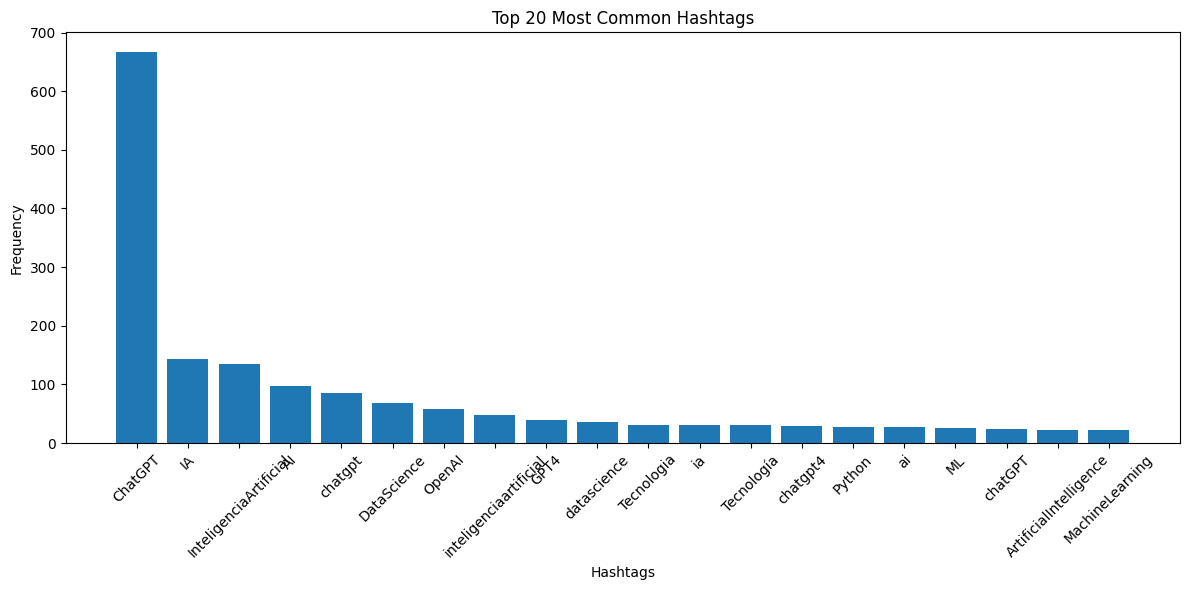

In [ ]:
# Plot the top 20 hashtags
plt.figure(figsize=(12, 6))
plt.bar([tag for tag, count in most_common_hashtags], [count for tag, count in most_common_hashtags])
plt.title("Top 20 Most Common Hashtags")
plt.xlabel("Hashtags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Save the top hashtags to a new file for reference
hashtag_analysis_file_path = '/content/hashtag_analysis.xlsx'
pd.DataFrame(most_common_hashtags, columns=['Hashtag', 'Frequency']).to_excel(hashtag_analysis_file_path, index=False)

hashtag_analysis_file_path

'/content/hashtag_analysis.xlsx'

# **7. Topic Modeling**

In [ ]:
# Convert tokenized data to strings for CountVectorizer
df['preprocessed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))



In [ ]:
# Create a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(df['preprocessed_text'])

In [ ]:
# Apply LDA
num_topics = 5  # You can adjust this number as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
# Display the top words for each topic
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

num_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), num_top_words)

Topic 1:
datascience aquí vamos hacer si ai midjourney siempre dataanalytics aprender

Topic 2:
ia inteligencia artificial cómo puede ai tecnología si ser sabe

Topic 3:
ia openai gpt4 tecnología musk elon inteligencia expertos bard google

Topic 4:
artificial inteligencia datascience ahora ai ia openai cómo chat día

Topic 5:
ia datos ai datascience artificial openai inteligencia gpt3 ml chat



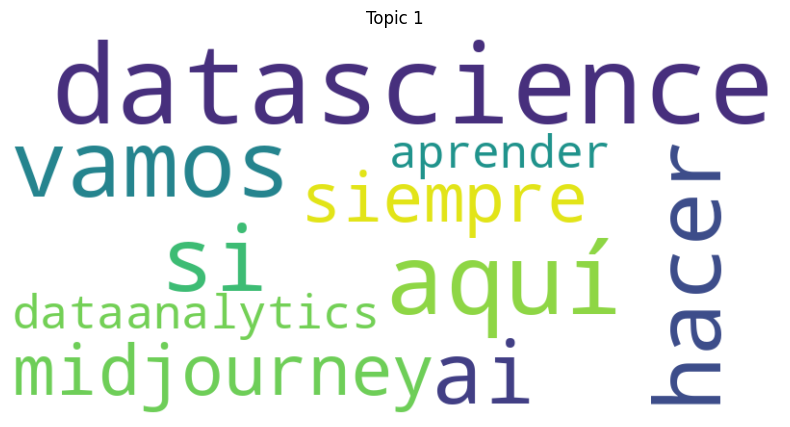

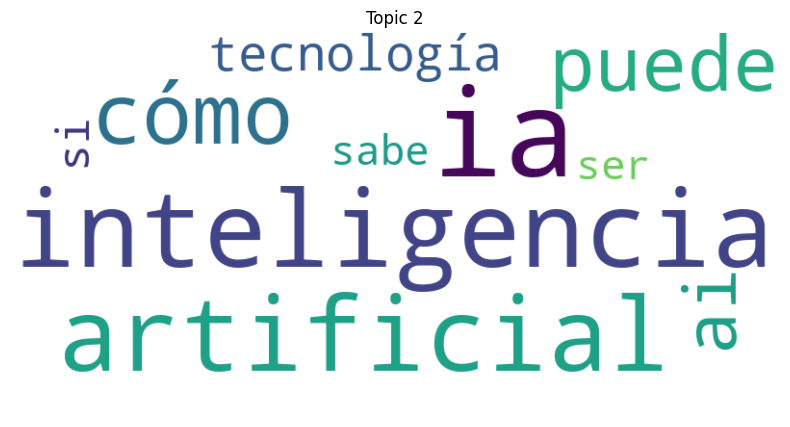

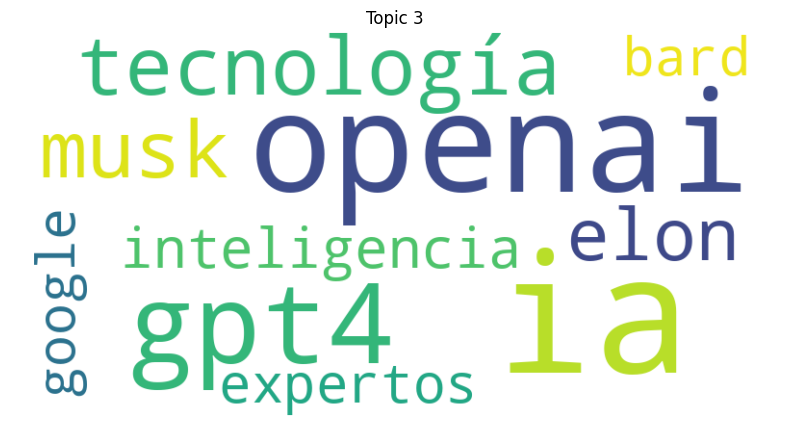

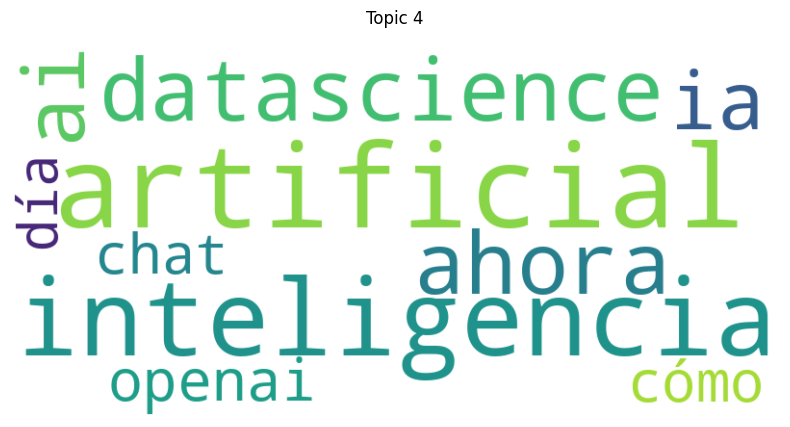

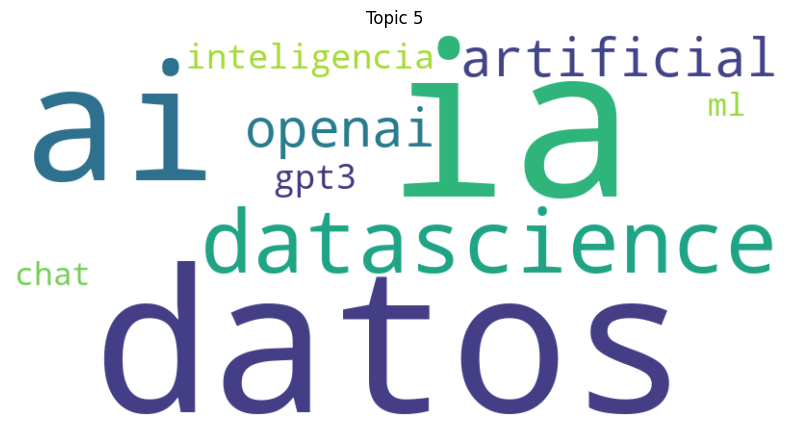

In [ ]:
# Visualize the topics using word clouds
for topic_idx, topic in enumerate(lda.components_):
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies({vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[:-num_top_words - 1:-1]})

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx + 1}")
    plt.axis('off')
    plt.show()

# **8. Results Visualization**

In [ ]:
/content/